In [0]:
import numpy as np
import pandas as pd
import json
import re
import matplotlib.pyplot as plt

from google.colab import drive
from tqdm import tqdm
from geopy.distance import geodesic
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import OneClassSVM
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
get_ipython().run_line_magic('matplotlib', 'inline')

In [59]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Data Cleaning and preprocessing


In [60]:

data = pd.read_csv('/content/gdrive/My Drive/find-the-cluster/clean_data_20200329.csv')
data['symptoms'] = data['symptoms'].str.replace("{}", '')
data = data[data.symptoms != ""]
data = data.dropna(subset=['symptoms', 'latitude', 'longitude'])
data = data[['symptoms', 'travel_history', 'latitude', 'longitude']]
data = data.reset_index()

features = set()
for i in tqdm(range(len(data))):
    data.at[i, 'symptoms'] = data.at[i, 'symptoms'].replace("\'", "\"")
    data.at[i, 'symptoms'] = re.findall('"([^"]*)"', data.at[i, 'symptoms'])
    for element in data.at[i, 'symptoms']:
        if 'others' not in element:
            features.add(element)
        # i will use only whether the patient have traveled or not for prediction
    if "[]" in data.at[i, 'travel_history']:
        data.at[i, 'travel_history'] = 0
    else:
        data.at[i, 'travel_history'] = 1
features.add('travel_history')
features.add('latitude')
features.add('longitude')

# add one hot encoding
print(features)
data.reset_index()
one_hot_encoded = pd.DataFrame()
for entry in features:
    one_hot_encoded[entry] = 0

for i in tqdm(range(len(data))):
    new_row = []
    for entry in features:
        if 'latitude' in entry:
            new_row.append(data.at[i, 'latitude'])
        elif 'longitude' in entry:
            new_row.append(data.at[i, 'longitude'])
        elif 'travel_history' in entry:
            new_row.append(data.at[i, 'travel_history'])
        # the symptoms (search)
        else:
            found = False
            for symptom in data.at[i, 'symptoms']:
                if entry in symptom:
                    new_row.append(1)
                    found = True
            if not found:
                new_row.append(0)
    one_hot_encoded = one_hot_encoded.append(pd.Series(new_row, index=one_hot_encoded.columns), ignore_index=True)

long_lat = one_hot_encoded[['latitude', 'longitude']]

one_hot_encoded




 14%|█▍        | 87/603 [00:00<00:00, 864.32it/s]

{'nausea_vomiting', 'lesions on chest radiographs', 'latitude', 'hypertension', 'headache', 'little sputum', 'sneezing', 'light_headedness', 'sore_throat', 'digestive discomfort', 'longitude', 'chills_sweating', 'runny_nose', 'breathing_difficulty', 'sputum', 'eye irritation', 'nasal congestion', 'chest_pain', 'abdominal_pain', 'fatigue_weakness', 'somnolence', 'travel_history', 'fever', 'full body slump', 'cough', 'phlegm', 'diarrhea', 'conjunctivitis', 'body_ache'}


100%|██████████| 603/603 [00:00<00:00, 905.42it/s]


,nausea_vomiting,lesions on chest radiographs,latitude,hypertension,headache,little sputum,sneezing,light_headedness,sore_throat,digestive discomfort,longitude,chills_sweating,runny_nose,breathing_difficulty,sputum,eye irritation,nasal congestion,chest_pain,abdominal_pain,fatigue_weakness,somnolence,travel_history,fever,full body slump,cough,phlegm,diarrhea,conjunctivitis,body_ache
0,0.0,0.0,22.653890,0.0,0.0,0.0,0.0,0.0,0.0,0.0,114.129100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,22.653890,0.0,0.0,0.0,1.0,0.0,0.0,0.0,114.129100,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.0,0.0,22.653890,0.0,0.0,0.0,0.0,0.0,0.0,0.0,114.129100,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,22.653890,0.0,0.0,0.0,0.0,0.0,1.0,0.0,114.129100,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,22.158910,0.0,0.0,0.0,0.0,0.0,0.0,0.0,113.561100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
598,0.0,0.0,-22.908300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-43.196400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
599,0.0,0.0,-22.885927,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-43.115259,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
600,0.0,0.0,-29.682590,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-51.059200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
601,0.0,0.0,-36.600000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-71.750000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


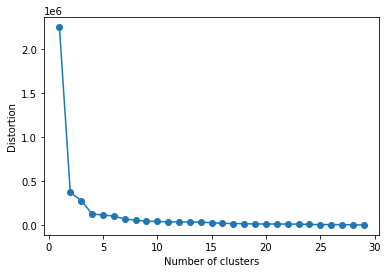

In [61]:
# run k-means multiple times with different values of k to determine the 
# optimal value using the elbow method

distortions = []
for i in range(1, 30):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(long_lat)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 30), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

[[ 28.44354499 110.97118896]
 [ -7.70391916 -56.1178716 ]
 [ 37.70594734 137.67169014]
 [ 50.91364414   3.413314  ]]


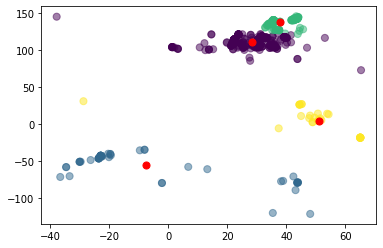

In [62]:
# optimal number of clusters for this dataset is 4
# this may increase when our dataset increases in size
Kmean = KMeans(n_clusters=4)
Kmean.fit(long_lat)
centroids = Kmean.cluster_centers_
print(centroids)
plt.scatter(long_lat['latitude'], long_lat['longitude'], c= Kmean.labels_.astype(float), s=50, alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)
plt.show()

In [0]:
def findDistance(coords_1,coords_2):
    return geodesic(coords_1, coords_2).km

In [64]:
for i,x in enumerate(centroids):
    col_name = f'cluster_distance_{i}'
    long_lat[col_name] = long_lat[['latitude','longitude']].apply(lambda arr: findDistance(arr, x),axis=1)
long_lat = long_lat.drop(['longitude', 'latitude'], axis = 1)
one_hot_encoded = one_hot_encoded.drop(['longitude', 'latitude'], axis = 1)
data = pd.concat([long_lat, one_hot_encoded], axis=1, sort=False)

data

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,cluster_distance_0,cluster_distance_1,cluster_distance_2,cluster_distance_3,nausea_vomiting,lesions on chest radiographs,hypertension,headache,little sputum,sneezing,light_headedness,sore_throat,digestive discomfort,chills_sweating,runny_nose,breathing_difficulty,sputum,eye irritation,nasal congestion,chest_pain,abdominal_pain,fatigue_weakness,somnolence,travel_history,fever,full body slump,cough,phlegm,diarrhea,conjunctivitis,body_ache
0,715.504995,18056.212483,2801.284706,9429.741335,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1,715.504995,18056.212483,2801.284706,9429.741335,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
2,715.504995,18056.212483,2801.284706,9429.741335,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,715.504995,18056.212483,2801.284706,9429.741335,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,743.371125,18068.756102,2881.424283,9439.117919,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
598,17370.373069,2177.630250,18361.415599,9365.518392,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
599,17361.694446,2181.299324,18359.303133,9359.475135,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
600,18275.822538,2489.901700,18812.362670,10403.581582,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
601,19065.777604,3571.531391,17418.985789,12149.707127,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [109]:
X = data.to_numpy()
X = StandardScaler().fit_transform(X)
pca = PCA(n_components=29, svd_solver='full')
X = pca.fit_transform(X)
print(np.sum(pca.explained_variance_ratio_))
print(X.shape)
np.random.shuffle(X)
X_train, X_test = X[:550], X[550:]
print(X_train[0])
print(X_test[0])

0.9971966534286879
(603, 29)
[ 6.08838306e+00  2.19038022e-01 -7.37664026e-01 -3.22319081e+00
 -3.67467823e+00  1.99259484e+00 -5.61290055e-01 -3.60021126e-01
 -4.48034323e-01  9.02296403e-02  5.59367001e-01 -4.05394525e-01
  3.53121487e-02 -8.69516908e-02  2.01781442e-03 -5.70172707e-01
 -3.74192726e-01  6.94811811e-01  4.90108594e-01  6.55719259e-01
  1.92280127e-01 -4.19030191e-02 -1.83598026e-01 -3.82048759e-01
 -4.28869753e+00  2.16397067e+00 -3.94820577e-01 -1.31585431e+00
 -1.95249740e+00]
[-1.23372901  2.49912316  0.20999475  1.80808426  0.0798879   0.41333173
 -0.18771302  2.47267206 -1.77090836  0.47894943 -0.45711659 -0.11252594
  0.53956001  0.35906028 -0.1359175   0.16163242  0.23795809 -0.73768765
 -1.30930667 -0.50622241 -0.56261152 -0.66517929  0.28855035 -2.40087684
 -1.59954612  0.48092822 -0.04506421  0.98384049  0.3626491 ]


# Building model

In [0]:
def sigmoid(x):
    return 1/(1 + np.exp(-x)) 

In [111]:
clf = OneClassSVM(gamma='auto').fit(X_train)

# dist is +ve for an inlier and -ve for an outlier
dist_from_boundary = clf.decision_function(X_test)
probs = sigmoid(dist_from_boundary)
pred = clf.predict(X_test)
true = np.ones(53)
print(dist_from_boundary)
print(probs)
print(pred)

[-31.87492083  11.1261593   10.15396483  11.15449537 -27.68750487
   9.28741629  10.88036236 -30.8415834  -22.86604015  -6.18239875
  10.64797624 -14.72778473 -29.33514949 -67.4192799   10.78656768
   8.76437306 -44.90967824  10.07616231  -0.41784706  10.22130348
  10.71468532   0.19004673 -55.80306589  10.94622182  10.07616231
 -55.87636891  11.12204372 -56.38384114  10.29413321 -12.43596461
  10.40027952  10.17938825   8.72292349  11.6435802   11.24170008
   0.5193055  -17.66484487  10.05399778  11.13203485 -43.0822476
  11.18777413   8.44849393 -14.73108655 -46.16015482 -56.27731552
   9.22705043 -22.45116678   7.66490348 -24.26242805  10.36585481
 -24.01422244  10.36585481  11.19051855]
[1.43515157e-14 9.99985278e-01 9.99961080e-01 9.99985689e-01
 9.45081834e-13 9.99907427e-01 9.99981176e-01 4.03339278e-14
 1.17328884e-10 2.06121001e-03 9.99976252e-01 4.01609693e-07
 1.81930893e-13 5.25023527e-30 9.99979325e-01 9.99843824e-01
 3.13310217e-20 9.99957931e-01 3.97032044e-01 9.99963614

In [112]:
accuracy_score(true, pred)

0.5849056603773585